The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Gráfico salvo como 'Images/WindSpeed.eps'


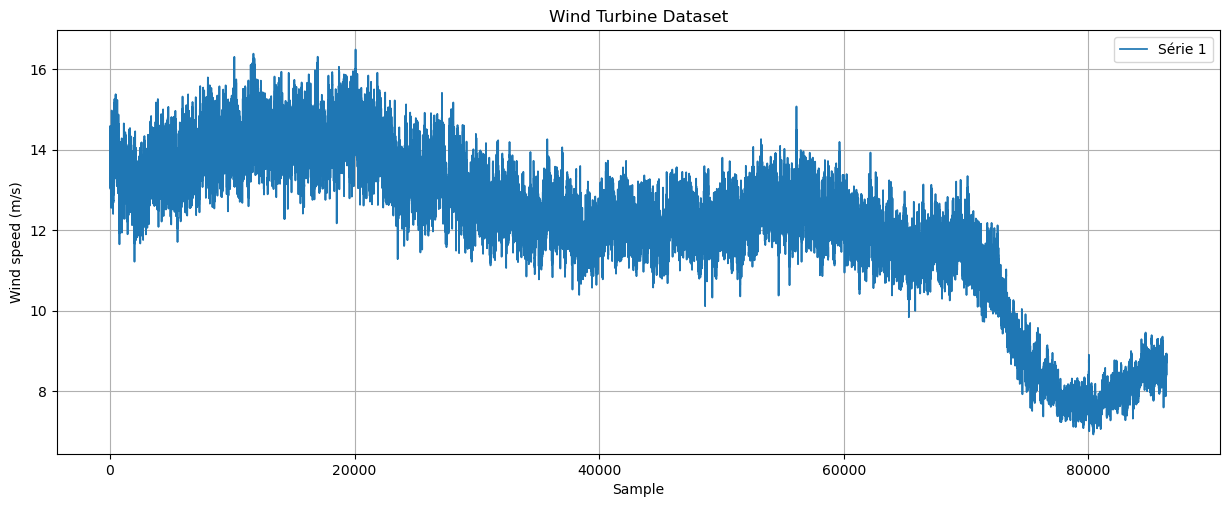

In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
from scipy.io import netcdf
import math
import time
import matplotlib.pyplot as plt
from importlib import reload
from IPython.display import clear_output
import _GraphUtils as gu
import _DriveTrain as dt
import _StateObserver as so
import _ReferenceConverter as rc
import _FeedbackController as fc

reload(gu)
reload(dt)
reload(so)
reload(rc)
reload(fc)

params = {
    "Bdt": 755.49,
    "Kdt": 2.7*1e9,
    "Jg": 55*1e6,
    "Jr": 55*1e6,
    "rho": 1.225,
    "Ar": math.pi * (57.5**2),
    "Rr":  57.5,
    "Cp_Max": 0.486,
    "Lambda_opt": 7.6,
    "Dmax": 1000,
    "Vmax": 5,
    "Vmin": 0.2
}

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100) 

path = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*4

gu.PlotSeries(y_arrays=[v[:]],w=15,h=5.5,yname=r'Wind speed (m/s)', xname='Sample', title='Wind Turbine Dataset',pltly=False, file_name=r'Images/WindSpeed.eps',save=True,lw=1.25)

In [2]:
dTrain = dt.DriveTrain(**params)
X=np.array([1,1,0])
dTrain.set_state(X)
stps = 1
e = len(v)
for i,v_ in enumerate(v[:1000]):
    #print(i,'/',len(v))
    #if i%5==0: clear_output(wait=False)
    U = dTrain.compute_input(v_,X,uk=0)
    X = dTrain.iterate(U,1)
    dTrain.compute_output()

In [ ]:
all_plots = dTrain.all_plots()
gu.MultiPlot(all_plots, rows=3, cols=5, pltly=False, main_title=None, fig_size=(12,6), file_name=r'Images/PowerEnergyDissipation.png', save=False)

In [3]:
RUL_ref,D_max=len(v), 1000
dTrain2 = dt.DriveTrain(**params)
sObserver_ = so.StateObserver(TS=1,c=1e-5,D=0.01, B=0.01, **params)
sObserver_.solve_lmi_gain()
rConverter_ = rc.ReferenceConverter(RUL_ref,D_max)
fController_ = fc.FeedbackController(**params)
fController_.solve_lqr_gain()
ls1_,ls2_,uk_,btr_,bth_,d_,dif_,rul_r,k = [],[],[],[],[],[],[],[],[]
X=np.array([0.1,0.1,0])
dTrain2.set_state(X)
uk = 0
for i in range(len(v[:])):
    #print(i,'/',len(v))
    #if i%5==0: clear_output(wait=False)
    U = dTrain2.compute_input(v[i],X,uk=uk)
    X = dTrain2.iterate(U,1)
    dTrain2.compute_output()
    EDK = dTrain2.ED[-1]
    if i >0 and i%10 == 0:
        D_hat, beta_hat = sObserver_.update(y_k=EDK)
        beta_ref = rConverter_.update(D_hat)
        lambda_star, uk = fController_.update(beta_hat, beta_ref, dt=1)
        ls1_.append(lambda_star)
        uk_.append(uk)
        btr_.append(beta_ref)
        bth_.append(beta_hat)
        d_.append(D_hat)
        dif_.append(rConverter_.D_max-D_hat)
        rul_r.append(rConverter_.rul_ref)
        k.append(rConverter_.k)
        if D_hat>D_max: 
            print('Break!!!!')
            break

In [ ]:
all_plots = dTrain2.all_plots()
gu.MultiPlot(all_plots, rows=3, cols=5, pltly=False, main_title=None, fig_size=(12,6), file_name=r'Images/PowerEnergyDissipation.png', save=False)

Multi-plot salvo como 'Images/SimuRes1_v3.png'


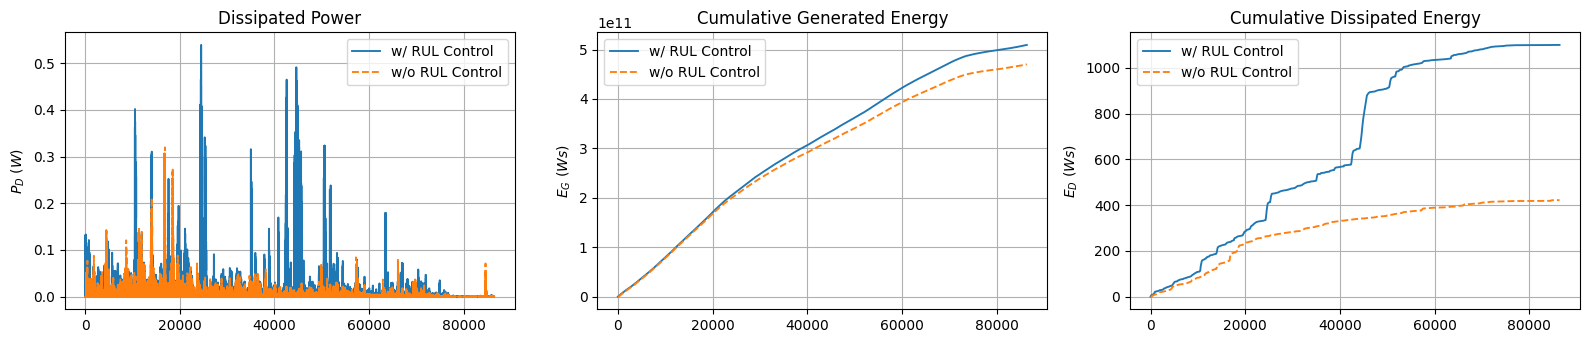

Multi-plot salvo como 'Images/SimuRes2_v3.png'


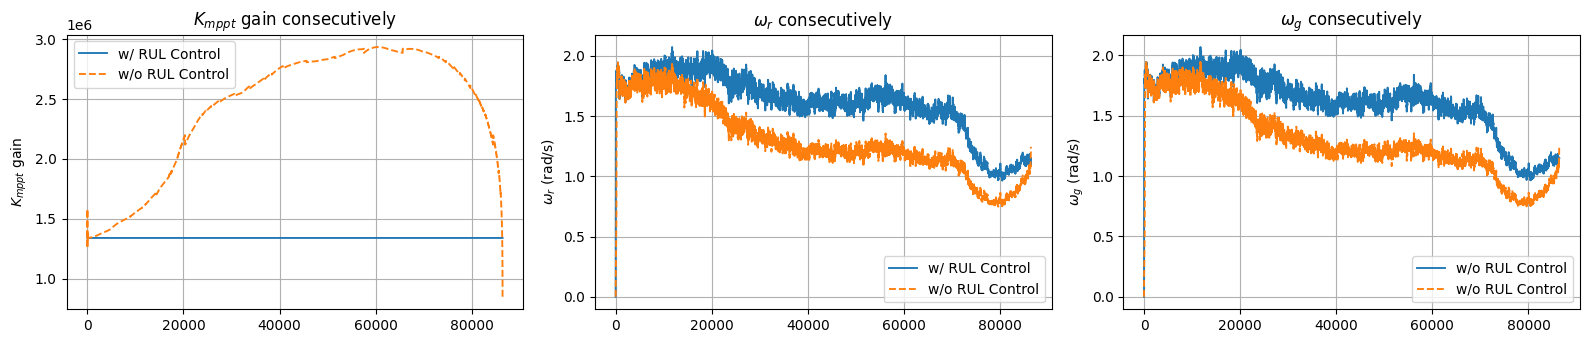

Multi-plot salvo como 'Images/SimuRes2_v3.png'


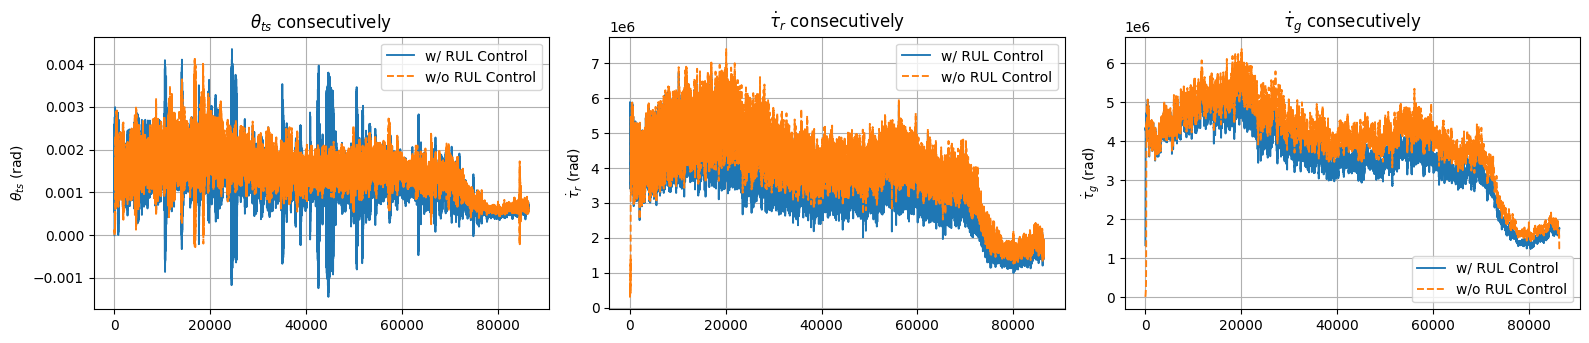

In [13]:
all_plots = gu.AllPlots(dTrain,dTrain2)
w_, h_,  = 8, 2
nrows, ncols = 1, 3
gu.MultiPlot(all_plots[1:4], rows=nrows, cols=ncols, pltly=False, main_title=None, fig_size=(w_*2,h_*2), file_name=r'Images/SimuRes1_v3.png', save=True, lw=1.35)
gu.MultiPlot(all_plots[4:7], rows=nrows, cols=ncols, pltly=False, main_title=None, fig_size=(w_*2,h_*2), file_name=r'Images/SimuRes2_v3.png', save=True, lw=1.35)
gu.MultiPlot(all_plots[7:8]+all_plots[-2:], rows=nrows, cols=ncols, pltly=False, main_title=None, fig_size=(w_*2,h_*2), file_name=r'Images/SimuRes2_v3.png', save=True, lw=1.35)


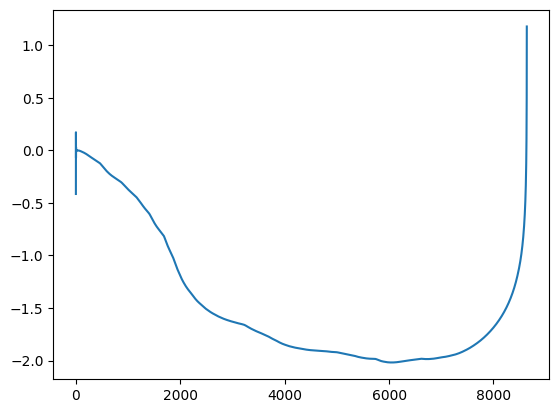

In [15]:
plt.plot(uk_)